# Behavioral state from trial outcomes
This notebook describes how to load and process data from {cite}`Hulsey2024` to evaluate the behavioral state of mice performing perceptual decision tasks, given trial outcomes. It also shows how to evaluate the relation between these behavioral states and arousal (as indexed by pupil size) and uninstructed movements (such as whisking, and locomotion).

## To do:
* Add citation to references.bib

### Environment Setup

In [1]:
try:
    from databook_utils.dandi_utils import dandi_download_open
except:
    #!git clone https://github.com/AllenInstitute/openscope_databook.git
    #%cd openscope_databook
    #%pip install -e .
    pass

In [2]:
from dandi import dandiapi
from pynwb import NWBHDF5IO
import numpy as np
import warnings
import re
import matplotlib.pyplot as plt
import ssm
import random

## Load NWB file with behavior data

In [3]:
dandiset_id = "000678"
#dandi_filepath = "sub-BW046/sub-BW046_ses-20211110T084031.nwb"
dandi_filepath = "sub-BW058/sub-BW058_ses-20220304T092331.nwb"
download_loc = "."
dandi_api_key = None

In [4]:
# Ignore "UserWarning: Ignoring cached namespace..." warning from pynwb 
msg = "Ignoring cached namespace"
warnings.filterwarnings("ignore", message=msg)

In [5]:
# This can sometimes take a while depending on the size of the file
io = dandi_download_open(dandiset_id, dandi_filepath, download_loc, dandi_api_key=dandi_api_key)
nwb = io.read()

A newer version (0.61.2) of dandi/dandi-cli is available. You are using 0.55.1


File already exists
Opening file


In [6]:
print(nwb.session_description)

Behavior data. Two-alternative choice visual/auditory discrimination.


## Preprocess the trial data

Some of the variables in our table of trials contain enumerated values. For example, `choice` can be either `0`, `1` or `2` representing *left*, *right*, or *no_lick*, respectively. This mapping is stored in the description field of each variable in the NWB file. The following function loads the data and these mappings.

In [7]:
def read_trial_data(nwbFileObj):
    """
    Return trial information and dictionary mapping labels to integer values from open nwb file.
    Args:
        nwbFileObj (object): an open nwbfile object.
    Returns:
        trial_data (pd.DataFrame): each rows is one trial, columns are variables recorded on each trial.
        trial_labels (dict): dictionary of dictionaries containing mapping of values to labels.
    """
    trial_data = nwbFileObj.trials.to_dataframe()
    stage = nwbFileObj.lab_meta_data['metadata'].training_stage
    trial_data['stage'] = stage  # Add the training stage to the dataframe
      
    # Create dict of trial_labels stored in the description of each trial variable
    trial_labels = {}
    pattern = r"MAP:(\{.*\})"
    for key in nwbFileObj.trials.colnames:
        match = re.search(pattern, nwbFileObj.trials[key].description)
        if match:
            dict_string = match.group(1)
            trial_labels[key] = eval(dict_string)
    return trial_data, trial_labels

To read the trial data we can simply run:

In [8]:
trial_data, trial_labels = read_trial_data(nwb)

We end up with a pandas dataframe with the trial data:

In [9]:
trial_data

,start_time,stop_time,target_modality,cue_time,cue_ID,cue_duration,stimulus_type,stimulus_time,stimulus_duration,target_port,auditory_stim_id,auditory_stim_band,auditory_stim_difficulty,visual_stim_id,visual_stim_oreintation,visual_stim_difficulty,visual_gabor_angle,outcome,choice,stage
id,,,,,,,,,,,,,,,,,,,,
0,63.361480,65.631458,1.0,63.361480,0.0,0.0,0.0,63.362478,1200.0,1.0,2.0,1.0,NaN,1.0,0.0,0.0,90.0,1.0,1.0,S5
1,77.024757,78.266354,1.0,77.024757,0.0,0.0,0.0,77.024757,1200.0,1.0,2.0,1.0,NaN,1.0,0.0,2.0,54.0,2.0,0.0,S5
2,83.887508,85.152193,1.0,83.887508,0.0,0.0,0.0,83.888505,1200.0,1.0,2.0,1.0,NaN,1.0,0.0,2.0,54.0,2.0,0.0,S5
3,89.685163,90.954926,1.0,89.685163,0.0,0.0,0.0,89.685163,1200.0,0.0,2.0,1.0,NaN,0.0,1.0,2.0,36.0,1.0,0.0,S5
4,97.094898,98.361895,1.0,97.094898,0.0,0.0,0.0,97.095895,1200.0,0.0,2.0,1.0,NaN,0.0,1.0,1.0,18.0,1.0,0.0,S5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
598,5064.923639,5067.222984,1.0,5064.923639,0.0,0.0,0.0,5064.924634,1200.0,0.0,2.0,1.0,NaN,0.0,1.0,0.0,0.0,16.0,2.0,S5
599,5073.199804,5075.482593,1.0,5073.199804,0.0,0.0,0.0,5073.200799,1200.0,1.0,2.0,1.0,NaN,1.0,0.0,0.0,90.0,16.0,2.0,S5
600,5079.830451,5082.125913,1.0,5079.830451,0.0,0.0,0.0,5079.830451,1200.0,1.0,2.0,1.0,NaN,1.0,0.0,0.0,90.0,16.0,2.0,S5


And a dictionary of labels for categorical (enumerated) variables:

In [10]:
trial_labels

{'target_modality': {'auditory': 0, 'visual': 1},
 'cue_ID': {'A': 0, 'B': 1},
 'stimulus_type': {'target': 0, 'distractor': 1, 'both': 2},
 'target_port': {'left': 0, 'right': 1},
 'auditory_stim_id': {'left': 0, 'right': 1, 'no stim': 2},
 'auditory_stim_band': {'low_band': 0, 'high_band': 1},
 'visual_stim_id': {'left': 0, 'right': 1, 'no stim': 2},
 'visual_stim_oreintation': {'horizontal': 0, 'vertical': 1},
 'visual_stim_difficulty': {'45': 0, '36': 1, '27': 2, '18': 3, '9': 4},
 'outcome': {'timeout': 0,
  'hit': 1,
  'miss': 2,
  'false_alarm': 4,
  'correct_reject': 8,
  'incorrect_reject': 16},
 'choice': {'left': 0, 'right': 1, 'no_lick': 2}}

Because of the way stimulus values are stored, we also need to perform some preprocessing and convert stimulus values to a normalized scale in the range (-1, 1) for the target stimulus (either visual or auditory) of a given session. We achieve this normalization with the following function.

In [11]:
def normalize_stim_values(trial_data, trial_labels):
    """
    Normalize stimulus values to range (-1, 1).
    
    Args:
        trial_data (pd.DataFrame): each rows is one trial, columns are variables recorded on each trial.
        trial_labels (dict): dictionary of dictionaries containing mapping of values to labels.
        
    Returns:
        vis_stim (np.array):
        aud_stim (np.array):
    """
    aud_stim_direction = trial_data['auditory_stim_id'].values
    aud_stim_direction[np.where(aud_stim_direction==trial_labels['auditory_stim_id']['left'])[0]]=-1
    aud_stim_direction[np.where(aud_stim_direction==trial_labels['auditory_stim_id']['right'])[0]]=1
    aud_stim_direction[np.where(aud_stim_direction==trial_labels['auditory_stim_id']['no stim'])[0]]=np.nan
    aud_stim_value = trial_data['auditory_stim_difficulty'].values
    aud_stim_value = aud_stim_value-(1-aud_stim_value)/2
    aud_stim = aud_stim_direction*aud_stim_value

    vis_stim_direction =  trial_data['visual_stim_id'].values
    vis_stim_direction[np.where(vis_stim_direction==trial_labels['visual_stim_id']['left'])[0]]=-1
    vis_stim_direction[np.where(vis_stim_direction==trial_labels['visual_stim_id']['right'])[0]]=1
    vis_stim_direction[np.where(vis_stim_direction==trial_labels['visual_stim_id']['no stim'])[0]]=np.nan
    if any(trial_data.columns == 'visual_stim_difficulty'):
        vis_val = trial_data['visual_stim_difficulty'].values 
    else:
        vis_val = trial_data['visual_stim_id'].values
    vis_stim_id = np.zeros(len(trial_data))
    if any(trial_data.columns.values==['visual_gabor_angle']):
        stim_val = trial_data['visual_gabor_angle'].values
        stim_val = stim_val[~np.isnan(stim_val)]
        stim_val = ((stim_val - 45)/45)
        stim_val = np.flip(np.unique(abs(stim_val)))
        if len(stim_val)>0:
            for this_diff in np.flip(np.unique(vis_val)):
                ind = np.where(vis_val==this_diff)[0]
                vis_stim_id[ind]=stim_val[int(this_diff)]
    else:
        vis_stim_id[vis_val==1]=.8
        vis_stim_id[vis_val==2]=.6
        vis_stim_id[vis_val==0]=1
    vis_stim = vis_stim_direction*vis_stim_id
    return (vis_stim, aud_stim)


In this notebook, we will focus only on the target modality for a given session (either visual or auditory), so we will add one column to our dataframe with the normalized stimulus values for just that modality:

In [12]:
vis_stim, aud_stim = normalize_stim_values(trial_data, trial_labels)
if trial_data['target_modality'][0] == trial_labels['target_modality']['auditory']:
    trial_data['normalized_stim'] = aud_stim
elif trial_data['target_modality'][0] == trial_labels['target_modality']['visual']:
    trial_data['normalized_stim'] = vis_stim

We can test that our normalized stimulus values are now between -1 and 1 (with np.nan when stimuli from a different modality are presented).

In [13]:
np.unique(trial_data['normalized_stim'])

array([-1. , -0.6, -0.2,  0.2,  0.6,  1. ])

## Estimate psychometric performance across all trials

We first create a function to estimate the performance for each stimulus value (given the dataframe with trial data):

In [14]:
def estimate_psychometric(trial_data, trial_labels):
    """
    Quantify the fraction of trials each choice was made for each stimulus value.
    
    Args:
        trial_data (pd.DataFrame): each rows is one trial, columns are variables recorded on each trial.
        trial_labels (dict): dictionary of dictionaries containing mapping of values to labels.
        
    Returns:
        stim_values (np.array): possible stimulus values.
        psychometric (np.array): [nChoices, nStim] Fraction of trials with a specific choice.
    """
    stim_values = np.unique(trial_data['normalized_stim'])
    psychometric = np.full([len(trial_labels['choice']), len(stim_values)], np.nan)
    for ind_stim, stim_val in enumerate(stim_values):
        trials_this_stim = trial_data.query('normalized_stim==@stim_val')
        n_trials_this_stim = len(trials_this_stim)
        if n_trials_this_stim > 0:
            for choice_label, ind_choice in trial_labels['choice'].items():
                psychometric[ind_choice, ind_stim] = len(trials_this_stim.query('choice==@ind_choice'))/n_trials_this_stim
        else:
            psychometric[:, ind_stim] = np.nan
    return stim_values, psychometric

We can now estimate and plot the psychometric peformance across all trials in a session.

In [15]:
stim_values, psychometric  = estimate_psychometric(trial_data, trial_labels)
print(psychometric.shape)  # 3 choices (left, right, no_lick) x N stim values

(3, 6)


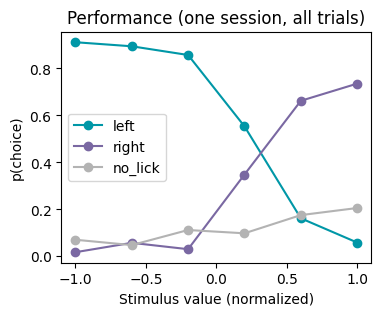

In [16]:
# Plot the psychometric curves
psy_colors = ['#0097A7', '#7A68A2', '0.7']
plt.figure(figsize=[4, 3])
for choice_label, ind_choice in trial_labels['choice'].items():
    plt.plot(stim_values, psychometric[ind_choice,:], '-o', color=psy_colors[ind_choice])
plt.ylabel('p(choice)')
plt.xlabel('Stimulus value (normalized)')
plt.legend(trial_labels['choice'].keys(), loc='center left')
plt.title('Performance (one session, all trials)');

## Estimate behavioral states from choices and trial outcomes

Here, we use a Hidden Markov Model with Generalized Linear Model emissions (GLM-HMM) to automatically characterize the dynamics in performance across trials in a session. This model estimates different performance states according to the choices the animal makes.

In [17]:
# Format the inputs for model fitting
choice = trial_data['choice'].to_numpy().astype(int)  # A 1-D array of ints indicating the choice on each trial
stim = trial_data['normalized_stim'].to_numpy()       # A 1-D array with the stim value on each trial
constant = np.ones(len(trial_data))                   # A constant to fit a bias term in our GLM
inputs = np.stack((stim, constant), axis=1)

# Model parameters
num_states = 3                             # Number of states of the HMM
obs_dim = 1                                # One observed dimension: the animal's choice.
num_categories = len(np.unique(choice))    # Number of possible choices
input_dim = inputs.shape[1]                # Two dimensions: stim value and bias coefficient

# Define the model
hmm = ssm.HMM(num_states, obs_dim, input_dim, observations="input_driven_obs", 
              observation_kwargs=dict(C=num_categories), transitions="standard")

We can now fit the model to our data.

In [18]:
# Let's fix the random seeds, so everyone gets the same results
np.random.seed(1)
random.seed(1)

# Fit an HMM to our data
TOL = 10**-4
N_iters = 1000
train_ll = hmm.fit(choice[:,None], inputs=inputs, method="em", num_iters=N_iters, tolerance=TOL)

  0%|          | 0/1000 [00:00<?, ?it/s]

After fitting the model, we can get the probability of being in each state for each trial.

In [19]:
# Get the array of posterior prob for each state on each trial (nTrials, nStates)
posterior_probs = hmm.expected_states(choice[:,None], input=inputs)[0]

# Estimate the state with maximum probability for each trial and add it to our dataframe
hmm_state = posterior_probs.argmax(axis=1)
trial_data['hmm_state'] = hmm_state

And plot these probabilities together with the choices on each trial.

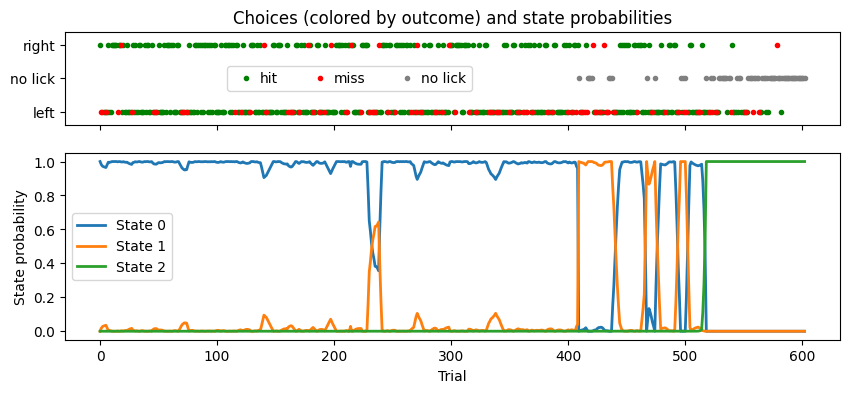

In [20]:
# Plot choices (colored by outcome) and probability of each state for each trial
outcomes_to_plot = {'hit':'g', 'miss':'r'}
ms = 3
state_colors = plt.get_cmap("tab10")(range(num_states))

fig, axs = plt.subplots(2, 1, gridspec_kw={'height_ratios': [1, 2]}, sharex=True, figsize=(10, 4))

axs[0] = plt.subplot(2, 1, 1)
for this_outcome, this_color in outcomes_to_plot.items():
    outcome_ind = trial_labels['outcome'][this_outcome]
    idx = np.flatnonzero(trial_data['outcome'] == outcome_ind)
    axs[0].plot(idx, choice[idx], 'o', color=this_color, ms=ms, label=this_outcome)
no_lick_idx = np.flatnonzero(choice==trial_labels['choice']['no_lick'])
axs[0].plot(no_lick_idx, np.tile(0.5, len(no_lick_idx)), 'o', color='0.5', ms=ms, label='no lick')
axs[0].set_yticks([0, 0.5, 1], ['left', 'no lick', 'right'])
axs[0].set_ylim([-0.2, 1.2])
axs[0].legend(loc='center left', ncol=3, bbox_to_anchor=(0.2, 0.5), handletextpad=0)
axs[0].set_title('Choices (colored by outcome) and state probabilities')

for inds in range(num_states):
    axs[1].plot(posterior_probs[:,inds], lw=2, color=state_colors[inds])
axs[1].set_ylabel('State probability')
axs[1].set_xlabel('Trial')
axs[1].legend([f'State {s}' for s in range(num_states)], loc='center left');

Note that **State 0** has a high probability when the animal makes mostly correct choices during the first half of the session (*optimal performance*). **State 1** has a high probability when the animal licks mostly to the left (*biased performance*). And **State 2** has a high probability when the animal is not licking much (*disengaged*).

Since we have an estimate of the performance state for each trial, we can calculate the psychometric performance for each state.

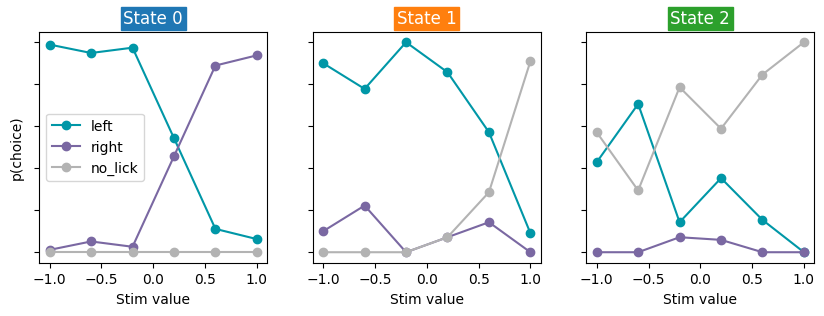

In [21]:
# Plot psychometric performance for each state
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(10, 3))
for state in range(num_states):
    trial_data_this_state = trial_data.query('hmm_state==@state')
    stim_vals, psychometric = estimate_psychometric(trial_data_this_state, trial_labels)
    for ind_choice, choice_probs in enumerate(psychometric):
        axs[state].plot(stim_vals, choice_probs, '-o', color=psy_colors[ind_choice])
    axs[state].set_ylim([-0.05, 1.05])
    axs[state].set_xlabel('Stim value')
    scolor = state_colors[state] 
    axs[state].set_title(f'State {state}', color='w', bbox={'fc':scolor, 'ec':scolor, 'pad': 2})
    axs[state].set_yticks(np.arange(0,1.1,.2))
    if state==0:
        axs[state].set_ylabel('p(choice)')
        axs[state].legend(trial_labels['choice'].keys())
    else:
        axs[state].set_yticklabels('')

Consistent with the observations above, **State 0** shows sharp psychometric curves that clearly depend on the stimulus value (*optimal*), **State 1*** shows a low probability of licking right (*biased*), and **State 2** shows a high probability of no licking for most stimulus values (*disengaged*). 

## Evaluate the dynamics of arousal and uninstructed movements

We now evaluate how arousal (estimated from pupil diameter) and uninstructed movements (such as running), relate to the behavioral states estimated from the animal's choices.

We start by loading the traces of these additional behavioral measures from our NWB file. Note that here, we focus on the value of each behavioral measure right before the stimulus presentation on each trial. 

In [22]:
behav_measures_labels = ['pupil_diameter', 'running_speed']
behav_measures = {}
for indb, measure in enumerate(behav_measures_labels):
    bmeasure_ts = nwb.get_acquisition(measure).timestamps[:]
    bmeasure_vals = nwb.get_acquisition(measure).data[:]
    
    # Find index of timestamp right before the trial start
    idx = np.searchsorted(bmeasure_ts, trial_data['start_time'], side='right')-1
    last_ts_before_trial_start = bmeasure_ts[idx]
    bmeasure_at_trial_start = bmeasure_vals[idx]
    
    behav_measures[measure] = {'ts':last_ts_before_trial_start, 'value':bmeasure_at_trial_start}

Once loaded, we can plot the value of each behavioral measure next to the probability of being in each state.

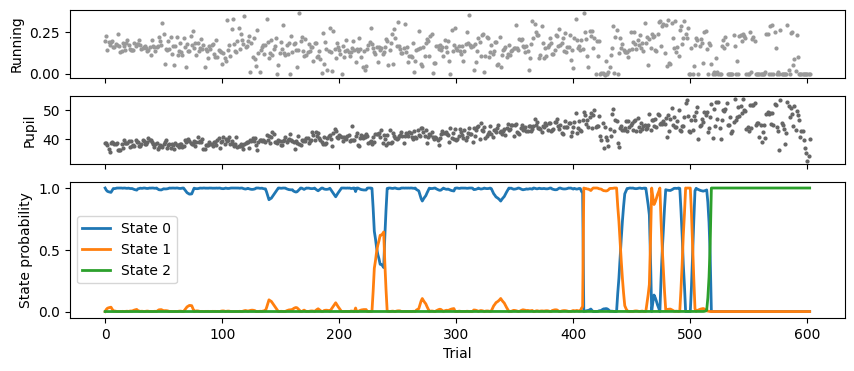

In [23]:
fig, axs = plt.subplots(3, 1, gridspec_kw={'height_ratios': [1, 1, 2]}, sharex=True, figsize=(10, 4))

axs[0].plot(behav_measures['running_speed']['value'],'.', color='0.6', ms=4, lw=0.1)
axs[0].set_ylabel('Running')
axs[1].plot(behav_measures['pupil_diameter']['value'],'.', color='0.4', ms=4, lw=0.1)
axs[1].set_ylabel('Pupil')
for inds in range(num_states):
    axs[2].plot(posterior_probs[:,inds], lw=2, color=state_colors[inds])
axs[2].set_ylabel('State probability')
axs[2].set_xlabel('Trial')
axs[2].legend([f'State {s}' for s in range(num_states)], loc='center left');

From these plots (from one example session) we can see a few things:
1. The disengaged state (State 2) seems to correlate with little running.
2. The disengaged state (State 2) seems to correlate with high variability in pupil size, while the optimal state (State 0) correlates with low variability in pupil size.
3. The pupil size seems to change at two time-scales: a long time-scale driving a slow increase throughout the session, and a fast time-scale that correlates with changes in performance state.

# Evaluate the relation between arousal and performance

From these data, we can also evaluate the relation between arousal (as indexed by pupil size) and performance. As mentioned above, the dynamics of pupil size seems to be driven by processes at multiple time-scales. To minimize the effects of the long time-scale and focus on the potential relation between pupil size and performance state, we focus here on the second half of the trials in the session. 

We first normalize the pupil size and estimate the probability of being in the optimal state (State 0) for each pupil size range.

In [24]:
pupil = behav_measures['pupil_diameter']['value']
normalized_pupil = (pupil-pupil.min())/(pupil.max()-pupil.min())

trials_to_exclude = range(0, 300)  # Exclude the first half of the session
state_to_plot = 0

bin_width = 0.1
bin_edges = np.arange(0, 1, bin_width)
prob_state_mean = np.empty(len(bin_edges))
prob_state_std = np.empty(len(bin_edges))
n_trials_each_bin = np.empty(len(bin_edges), dtype=int)
for inde, low_edge in enumerate(bin_edges):
    high_edge = low_edge + bin_width
    trials_this_bin = (normalized_pupil>low_edge) & (normalized_pupil<=high_edge)
    trials_this_bin[trials_to_exclude] = False  # NOTE: We focus only on a subset of trials
    prob_state_mean[inde] = np.mean(posterior_probs[trials_this_bin, state_to_plot])
    prob_state_std[inde] = np.std(posterior_probs[trials_this_bin, state_to_plot])
    n_trials_each_bin[inde] = np.sum(trials_this_bin)

Below is how many trials had a particular pupil size range:

In [25]:
n_trials_each_bin

array([ 1,  2,  6, 29, 57, 95, 47, 32, 20, 13])

We can now plot the probability of being in the optimal state (State 0) for each pupil size range.

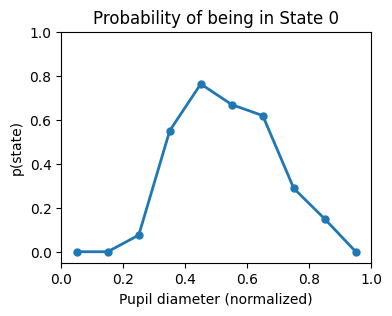

In [27]:
plt.figure(figsize=[4, 3])
color_this_state = state_colors[state_to_plot]
plt.plot(bin_edges+bin_width/2, prob_state_mean,'.-', ms=10, lw=2, color=color_this_state)
plt.ylabel('p(state)')
plt.xlabel('Pupil diameter (normalized)')
plt.ylim([-0.05,1])
plt.xlim([0,1])
plt.title(f'Probability of being in State {state_to_plot}');

We see that the probability of being in the optimal state is highest when the pupil is at an intermediate size, resulting in an inverted-U relationship between arousal and performance. 